In [22]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
import fastmri
from CLPmodel2 import *

from fastmri.data.subsample import RandomMaskFunc
from fastmri.data import subsample
from fastmri.data import transforms, mri_data

import torch.cuda

from fastmri.evaluate import *

In [23]:
mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])

def data_transform(kspace, mask, target, data_attributes, filename, slice_num):
    # Transform the data into appropriate format

    ifft_kspace = fastmri.ifft2c(T.to_tensor(kspace))
    crop_kspace = T.complex_center_crop(ifft_kspace, (320,320))   #torch.Size([640, 372, 2])
    orig_kspace = fastmri.fft2c(crop_kspace)
    masked_kspace, mask = T.apply_mask(orig_kspace, mask_func)  # apply the mask to k-space
                                                                # undersampled k-space data
    mr_img =  fastmri.ifft2c(masked_kspace)    # undersampled MR image
    
    return mr_img, masked_kspace, mask, target

dataset = mri_data.SliceDataset(
    root=pathlib.Path('./mimmox'),
    transform=data_transform,
    challenge='singlecoil'
)

In [55]:
def coso(x):
    # generate Gaussian pyramid for A
    img = x.squeeze(0).squeeze(0)
    #img =  fastmri.complex_abs(img)

    gpA = [img]
    for i in range(3):
        real = img[..., 0]
        imm = img[..., 1]
        Gr = cv2.pyrDown(real.detach().numpy())
        Gi = cv2.pyrDown(imm.detach().numpy())

        img = torch.stack((T.to_tensor(Gr), T.to_tensor(Gi)), dim=2)
        
        gpA.append(img)
    # generate Laplacian Pyramid for A
    
    lpA = []
    for i in range(3,0,-1):
        size = (gpA[i - 1].shape[1], gpA[i - 1].shape[0])
        g = gpA[i]
        real = g[..., 0].detach().numpy()
        imm = g[..., 1].detach().numpy()

        gg = gpA[i-1]
        
        GEr = cv2.pyrUp(real,  dstsize=size)
        GEi = cv2.pyrUp(imm,  dstsize=size)
     
        lr = cv2.subtract(gg[...,0].detach().numpy(), GEr)
        li = cv2.subtract(gg[...,1].detach().numpy(), GEi)
        
        L = torch.stack((T.to_tensor(lr), T.to_tensor(li)), dim=2)
        lpA.append(L)
    return gpA[2], lpA[2], lpA[1]


torch.Size([80, 80, 2])
torch.Size([320, 320, 2])
torch.Size([160, 160, 2])


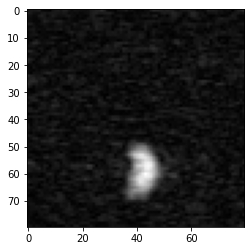

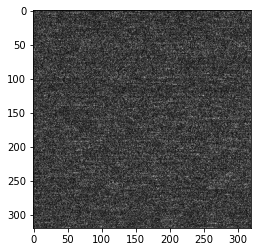

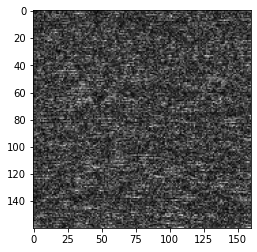

In [57]:

for mr_img, masked_kspace, mask, target in dataset:
    
    input1 = mr_img.unsqueeze(0).unsqueeze(0)
    a, b, c = coso(input1)
    
    print(a.shape)
    print(b.shape)
    print(c.shape)
    img = plt.figure()
    plt.imshow(fastmri.complex_abs(a), cmap='gray')
    img = plt.figure()
    plt.imshow(fastmri.complex_abs(b), cmap='gray')
    img = plt.figure()
    plt.imshow(fastmri.complex_abs(c), cmap='gray')
    break

In [19]:
%%time
import torch.optim as optim

net = Net()

criterion = nn.L1Loss()
optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.95, amsgrad=False)

psnr = PSNR()
ssim = SSIM()

avg_psnr_f = 0.0
avg_ssim_f = 0.0

for epoch in range(1):  # loop over the dataset multiple times
    
    running_loss = 0.0
    count_slice = 0
    avg_psnr = 0.0
    avg_ssim = 0.0
    
    for mr_img, masked_kspace, mask, target in dataset:
        
        input1 = mr_img.unsqueeze(0).unsqueeze(0)
        input2 = masked_kspace.unsqueeze(0).unsqueeze(0)
        
        a, b, c = coso(input1)
        
        
        outputs = net(input1, input2, mask)

        abs1 = fastmri.complex_abs(outputs[0][0])
        abs2 = transforms.to_tensor(target)

        loss = criterion(abs1, abs2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()

        avg_psnr += psnr(abs1, abs2).item()
        avg_ssim += ssim(abs1, abs2).item()

        count_slice += 1
        
        pass
    
    fig = plt.figure()
    plt.imshow(abs1.detach().numpy(), cmap='gray')
    plt.savefig('exo/epoch'+str(epoch+1)+'.jpg')
    plt.close()
    
    avg_psnr_f += avg_psnr/count_slice
    avg_ssim_f += avg_ssim/count_slice
    
    print('Epoch n° (%d) loss: %.3f' % (epoch + 1, running_loss))
    
    print("Average psnr: ", avg_psnr /count_slice)
    print("Average ssim: ", avg_ssim /count_slice)
    
print('Finished Training')
print("Average psnr tot: ", avg_psnr_f /1)
print("Average ssim tot: ", avg_ssim_f /1)

TypeError: Expected Ptr<cv::UMat> for argument 'src'

In [ ]:
PATH = './saved_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
print(count_slice)